## Generate Data using SAMMY

This notebook works to couple the (recently) open source SAMMY code from ORNL to calculate a RRR cross section. The advantage of coupling to SAMMY is its ability to efficiently apply experimental corrections.

In [2]:
from matplotlib.pyplot import *
import numpy as np
import pandas as pd
import os
# import nuctools

from ATARI.syndat.particle_pair import Particle_Pair
from ATARI.syndat.experiment import Experiment
from ATARI.syndat.MMDA import generate
from ATARI.scattering_theory.xs import SLBW
from ATARI.sammy_interface import sammy_interface

In [3]:
%matplotlib widget

In [4]:
ac = 0.81271    # scattering radius in 1e-12 cm 
M = 180.948030  # amu of target nucleus
m = 1           # amu of incident neutron
I = 3.5         # intrinsic spin, positive parity
i = 0.5         # intrinsic spin, positive parity
l_max = 1       # highest order l-wave to consider

Ta_pair = Particle_Pair( ac, M, m, I, i, l_max,
                                input_options={})

Ta_pair.map_quantum_numbers(True)


The following arrays describe all possible spin groups for a each parity.
    The data is given as a tuple where the first value is the integer 
    or half integer total quantum spin J and the second value is the 
    number of entrance channels for that spin group. 
    * See the dictionary "possible_Jpi" for a nested packing structure.

Spin group data for all parity
(Jpi, #Chs, l-waves)
(-5.0, 1, [1])
(-4.0, 2, [1, 1])
(-3.0, 2, [1, 1])
(-2.0, 1, [1])
(3.0, 1, [0])
(4.0, 1, [0])


In [5]:
### calc calculate a full energy grid yourself 
energy_grid = [500, 550]

### or just give the min/max and the experiment object will do the above
# energy_grid = E_min_max

input_options = {'Add Noise': True,
            'Calculate Covariance': True}

experiment_parameters = {'bw': {'val':0.0256,    'unc'   :   0}}

# initialize experimental setup
exp = Experiment(energy_grid, 
                        input_options=input_options, 
                        experiment_parameters=experiment_parameters)
len(exp.energy_domain)

207

In [6]:
spin_groups = [ (3.0,1,0) ]

# an alternative option would be to give Ta_pair.J, as long as you give an average parameter dataframe with corresponding indices
# spin_groups = Ta_pair.J

average_parameters = pd.DataFrame({ 'dE'    :   {'3.0':8.79, '4.0':4.99},
                                    'Gg'    :   {'3.0':64.0, '4.0':64.0},
                                    'gn2'    :   {'3.0':46.4, '4.0':35.5}  })
                                    
                                    
resonance_ladder = Ta_pair.sample_resonance_ladder(energy_grid, spin_groups, average_parameters)

resonance_ladder

,E,Gg,gnx2,J,chs,lwave,J_ID
0,509.349105,61.659755,12.912632,3.0,1.0,0.0,1.0
1,521.301355,68.028256,8.347212,3.0,1.0,0.0,1.0
2,531.138038,63.047086,0.382316,3.0,1.0,0.0,1.0
3,539.877913,66.968297,44.975815,3.0,1.0,0.0,1.0


### Calculate cross section using SAMMY and run experiment

In [7]:
theo = sammy_interface.calculate_xs(exp.energy_domain, resonance_ladder, Ta_pair,
                                            model = 'XCT',
                                            expertimental_corrections = 'all_exp',
                                            sammy_runDIR = 'SAMMY_runDIR',
                                            keep_runDIR=False   
                                            )
exp.run(theo)
# exp.redpar - exp.theo_redpar

### Below creates figures for the workflow figure

Text(0, 0.5, '$Counts/second$')

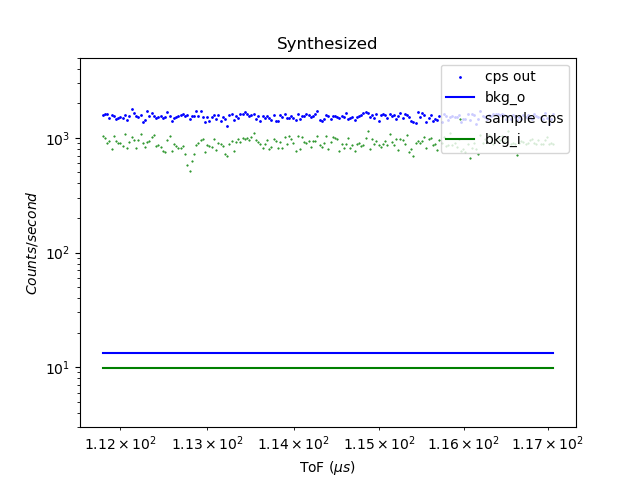

In [8]:
fig, ax = subplots()

scatter(exp.odat.tof,exp.odat.cps, label='cps out', color='b', s=1); 
plot(exp.odat.tof, exp.redpar.val.ko*exp.Bi+exp.redpar.val.b0o, label='bkg_o', color='b')

scatter(exp.sdat.tof,exp.sdat.cps,marker='.', s=1, label='sample cps', color='g')
# scatter(syndat_df.tof,syndat_df.theo_cts,marker='.', s=2, label='theo cts', color='k')
plot(exp.sdat.tof, exp.redpar.val.ks*exp.Bi+exp.redpar.val.b0s, label='bkg_i', color='g')


xscale('log'); yscale('log')
ylim([3,5e3])
# set_xlim([250,1.5e3])

title("Synthesized")
legend(loc='upper right')
xlabel('ToF ($\mu s$)')
ylabel('$Counts/second$')


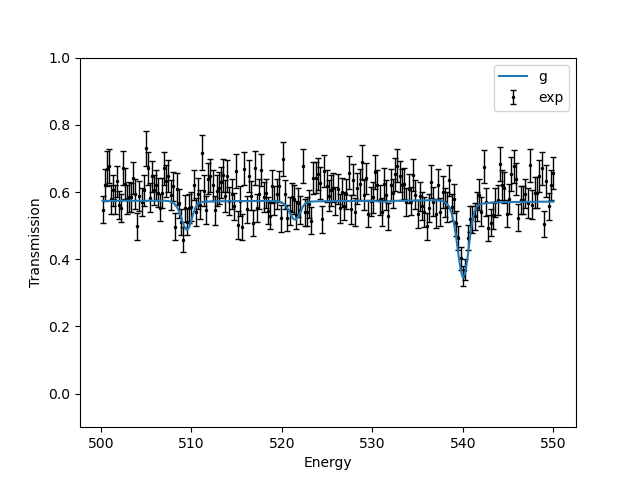

In [9]:
figure()
plot(theo.E, theo.theo_trans, ms=1, label='g')
errorbar(exp.trans.E, exp.trans.exp_trans, yerr=exp.trans.exp_trans_unc, zorder=0, 
                                        fmt='.', color='k', linewidth=1, markersize=3, capsize=2, label='exp')

# plot(exp.trans.E, exp.trans.theo_trans, color='g', lw=1, label='Sol', zorder=2)

ylim([-.1, 1])
# xscale('log')
xlabel('Energy'); ylabel('Transmission')
legend()

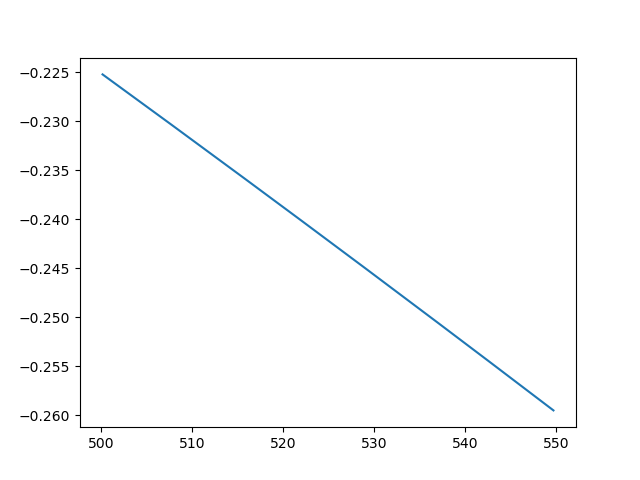

In [10]:
figure()

plot(exp.trans.E[1::], np.diff(exp.trans.E))